# Santander Value Prediction Challenge
   Predict the value of transactions for potential customers.

# Loading libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error,mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm
import gc
%matplotlib inline

In [2]:
df_train=pd.read_csv('../input/train.csv')
df_test=pd.read_csv('../input/test.csv')

In [3]:
print('Shape of training dataset: ',df_train.shape)
df_train.head()

Shape of training dataset:  (4459, 4993)


,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [4]:
print('Shape of test dataset: ',df_test.shape)
df_test.head()

Shape of test dataset:  (49343, 4992)


,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49343 entries, 0 to 49342
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


## Checking Missing Values

Defining function to check missing values and percentage of missing values in each column.

In [7]:
def check_missing_data(df):
    total=df.isnull().sum().sort_values(ascending=False)
    percent=((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    return pd.concat([total,percent],axis=1,keys=['Total','Percent'])

In [8]:
check_missing_data(df_train).head()

,Total,Percent
9fc776466,0,0.0
083640132,0,0.0
26e2c24e3,0,0.0
c3726f249,0,0.0
a682ef110,0,0.0


In [9]:
check_missing_data(df_test).head()

,Total,Percent
9fc776466,1,0.002027
0e931cdd3,1,0.002027
16bf5a9a2,1,0.002027
043e4971a,1,0.002027
c5da3db1d,1,0.002027


# Checking Unique Value in each column
Column with only one unique value is useless. There for we can drop these columns

In [10]:
df_tmp=pd.DataFrame(df_train.nunique().sort_values(),columns=['num_unique_values']).reset_index().rename(columns={'index':'Column_name'})
df_tmp.head()

,Column_name,num_unique_values
0,d9a8615f3,1
1,4a64e56e7,1
2,34cc56e83,1
3,19122191d,1
4,080540c81,1


In [11]:
def col_name_with_n_unique_value(df,n):
    df1=pd.DataFrame(df.nunique().sort_values(),columns=['num_unique_values']).reset_index()
    col_name=list(df1[df1.num_unique_values==1]['index'])
    print('number of columns with only',n,'unique values are: ',len(col_name))
    return col_name

In [12]:
col_to_drop=col_name_with_n_unique_value(df_train,1)

number of columns with only 1 unique values are:  256


### Droping unneccessary columns from train and test dataset

In [13]:
df_train.drop(columns=col_to_drop,inplace=True)
df_test.drop(columns=col_to_drop,inplace=True)
print('Shape of train dataset after droping columns: ',df_train.shape)
print('Shape of test dataset after droping columns: ',df_test.shape)

Shape of train dataset after droping columns:  (4459, 4737)
Shape of test dataset after droping columns:  (49343, 4736)


# Getting Dataset in numpy ndarray format

In [14]:
train=df_train.iloc[:,2:].values
test=df_test.iloc[:,1:].values
target=df_train.target.values
print('Shape of train: ',train.shape)
print('Shape of target: ',target.shape)
print('Shape of test: ',test.shape)

Shape of train:  (4459, 4735)
Shape of target:  (4459,)
Shape of test:  (49343, 4735)


In [15]:
del df_train,df_test,df_tmp
gc.collect()

21

# Visualization of target Column

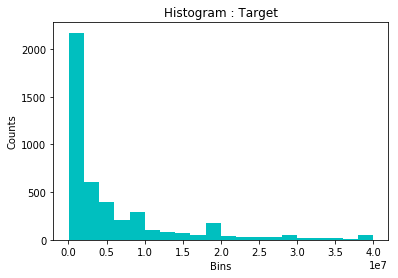

In [16]:
plt.hist(target, bins=20, color='c')
plt.title('Histogram : Target')
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.show()

Target values ranges from 0 to 4*1e7. there for taking log will reduce the range

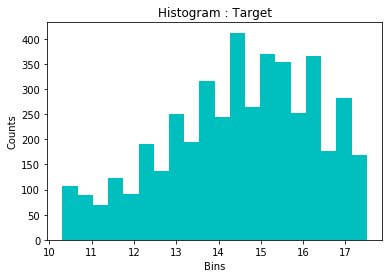

In [17]:
t=np.log1p(target)
plt.hist(t, bins=20, color='c')
plt.title('Histogram : Target')
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.show()

# Feature Scaling

In [18]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# D. Splitting dataset into Train, val and Test set
We split the dataset into train and val sets using an 80/20 split.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_sc, t, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(test_sc.shape, test_sc.shape)

NameError: name 'train_sc' is not defined

In [19]:
del train_sc,train,test
gc.collect()

7015

# Machine Learning Models

In [ ]:
Model_Summary=pd.DataFrame()

## 1. Lightgbm

In [20]:
import lightgbm
train_data=lightgbm.Dataset(X_train,y_train)
valid_data=lightgbm.Dataset(X_val,y_val)

NameError: name 'X_train' is not defined

In [ ]:
params={'learning_rate':0.01,
        'boosting_type':'gbdt',
        'objective':'regression',
        'metric':'rmse',
        'sub_feature':0.5,
        'num_leaves':180,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'min_data':50,
        'max_depth':-1,
        'reg_alpha': 0.3, 
        'reg_lambda': 0.1, 
        'min_child_weight': 10, 
        'verbose': 1,
        'nthread':5,
        'max_bin':512,
        'subsample_for_bin':200,
        'min_split_gain':0.0001,
        'min_child_samples':5
       }

In [ ]:
lgbm = lightgbm.train(params,
                 train_data,
                 25000,
                 valid_sets=valid_data,
                 early_stopping_rounds= 80,
                 verbose_eval= 10
                 )

In [ ]:
model_name='lightgbm'
RMSLE=np.sqrt(mean_squared_error(y_val,lgbm.predict(X_val)))
Model_Summary=Model_Summary.append({'Model_Name':model_name,'RMSLE':RMSLE},ignore_index=True)
Model_Summary

In [ ]:
pred_lgbm=np.expm1(lgbm.predict(test_sc))
pred_lgbm

## 2. CatBoostRegressor

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.1,
                             depth=5,
                             l2_leaf_reg=20,
                             bootstrap_type='Bernoulli',
                             subsample=0.6,
                             eval_metric='RMSE',
                             random_seed = 42,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=45)

In [ ]:
cb_model.fit(X_train, y_train,
             eval_set=(X_val, y_val),
             use_best_model=True,
             verbose=True)

In [ ]:
model_name='CatBoostRegressor'
RMSLE=np.sqrt(mean_squared_error(y_val,cb_model.predict(X_val)))
Model_Summary=Model_Summary.append({'Model_Name':model_name,'RMSLE':RMSLE},ignore_index=True)
Model_Summary

In [ ]:
pred_cb=np.expm1(cb_model.predict(test_sc))
pred_cb

## 3. RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100)

In [ ]:
rf_model.fit(X_train, y_train)

In [ ]:
model_name='RandomForestRegressor'
RMSLE=np.sqrt(mean_squared_error(y_val,rf_model.predict(X_val)))
Model_Summary=Model_Summary.append({'Model_Name':model_name,'RMSLE':RMSLE},ignore_index=True)
Model_Summary

In [ ]:
pred_rf=np.expm1(rf_model.predict(test_sc))
pred_rf

## 4. XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb_model=XGBRegressor(max_depth=9)

In [ ]:
xgb_model.fit(X_train, y_train)

In [ ]:
model_name='xgboost'
RMSLE=np.sqrt(mean_squared_error(y_val,xgb_model.predict(X_val)))
Model_Summary=Model_Summary.append({'Model_Name':model_name,'RMSLE':RMSLE},ignore_index=True)
Model_Summary

In [ ]:
pred_xgb=np.expm1(xgb_model.predict(test_sc))
pred_xgb

# Generating Submision File

**generating submission file for 4 model**

In [ ]:
Model_Summary

In [ ]:
sub=pd.read_csv('../input/sample_submission.csv')
sub.target=(pred_lgbm+pred_cb+pred_rf+pred_xgb)/4.0
sub.head()

In [ ]:
sub.to_csv('sub1.csv',index=False)